In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load interpolated data
data_interp = pd.read_csv("data/0901_Tek023_interpolated.csv")
# Load original data for comparison
data_original = pd.read_csv("data/0901_Tek023.csv")

print("Interpolated data shape:", data_interp.shape)
print("Original data shape:", data_original.shape)
data_interp.head()

Interpolated data shape: (500, 3)
Original data shape: (39, 3)


,t,log_t,vth_average
0,6.203855e-25,-20.723266,0.914897
1,6.182294e-11,-20.663279,0.914903
2,1.274680e-10,-20.603291,0.914920
3,1.971713e-10,-20.543304,0.914949
4,2.711840e-10,-20.483317,0.914989


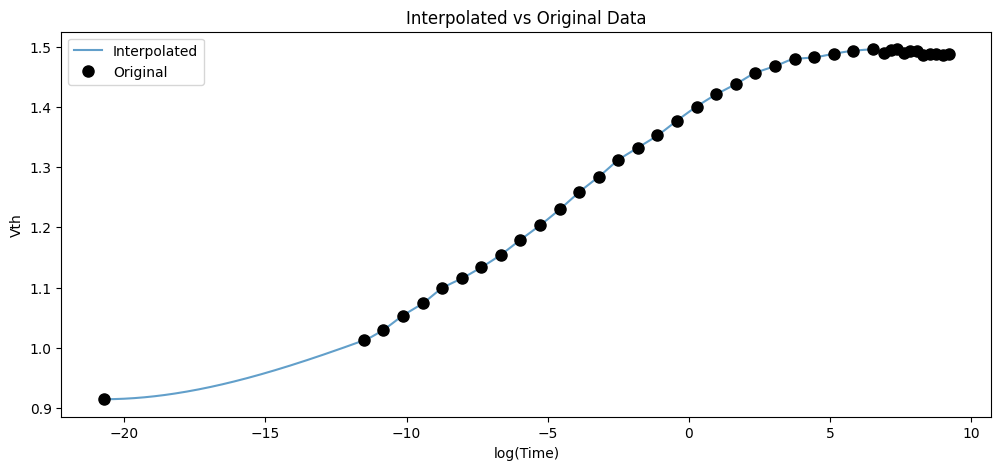

In [3]:
# Visualize interpolated vs original data
epsilon = 1e-9
plt.figure(figsize=(12, 5))
plt.plot(data_interp["log_t"], data_interp["vth_average"], '-', alpha=0.7, label="Interpolated")
plt.plot(np.log(data_original["t"] + epsilon), data_original["vth_average"], 'ko', markersize=8, label="Original")
plt.xlabel("log(Time)")
plt.ylabel("Vth")
plt.title("Interpolated vs Original Data")
plt.legend()
plt.show()

## Helper Functions for Metrics

In [4]:
def calculate_metrics(y_true, y_pred, name="Model"):
    """Calculate and print all metrics for a model."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{name}:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")
    
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

## Experiment 1: Train on first 1000s, predict 10000s+
Using interpolated data for training

In [5]:
# Prepare train/test data from interpolated dataset
train_mask = data_interp["t"] <= 1000
test_mask = data_interp["t"] > 1000

X_train = data_interp["log_t"][train_mask].values.reshape(-1, 1)
y_train = data_interp["vth_average"][train_mask].values

X_test = data_interp["log_t"][test_mask].values.reshape(-1, 1)
y_test = data_interp["vth_average"][test_mask].values

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 461
Test samples: 39


In [6]:
# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

### Random Forest

In [7]:
# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

print("=== Random Forest ===")
rf_train_metrics = calculate_metrics(y_train, y_pred_rf_train, "Train")
rf_test_metrics = calculate_metrics(y_test, y_pred_rf_test, "Test")

=== Random Forest ===

Train:
  MSE:  0.000000
  RMSE: 0.000284
  MAE:  0.000223
  R²:   0.999998

Test:
  MSE:  0.000009
  RMSE: 0.003014
  MAE:  0.002707
  R²:   -0.013196


### MLPRegressor (Neural Network)

In [8]:
# Train MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=2000, random_state=42)
mlp.fit(X_train_scaled, y_train)

y_pred_mlp_train = mlp.predict(X_train_scaled)
y_pred_mlp_test = mlp.predict(X_test_scaled)

print("=== MLPRegressor ===")
mlp_train_metrics = calculate_metrics(y_train, y_pred_mlp_train, "Train")
mlp_test_metrics = calculate_metrics(y_test, y_pred_mlp_test, "Test")

=== MLPRegressor ===

Train:
  MSE:  0.000207
  RMSE: 0.014390
  MAE:  0.011960
  R²:   0.995224

Test:
  MSE:  0.006076
  RMSE: 0.077948
  MAE:  0.074334
  R²:   -676.439442


### LSTM Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Scale for LSTM
scaler_X_lstm = MinMaxScaler()
scaler_y_lstm = MinMaxScaler()

X_train_lstm_scaled = scaler_X_lstm.fit_transform(X_train)
X_test_lstm_scaled = scaler_X_lstm.transform(X_test)
y_train_lstm_scaled = scaler_y_lstm.fit_transform(y_train.reshape(-1, 1))

# Reshape for LSTM: (samples, timesteps, features)
X_train_lstm = X_train_lstm_scaled.reshape((X_train_lstm_scaled.shape[0], 1, 1))
X_test_lstm = X_test_lstm_scaled.reshape((X_test_lstm_scaled.shape[0], 1, 1))

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(1, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train with early stopping
early_stop = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
history = lstm_model.fit(X_train_lstm, y_train_lstm_scaled, epochs=200, verbose=1, callbacks=[early_stop])

Epoch 1/200


/Users/titanjuels/Documents/HKUST/FYP/model/fypenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3028
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2153
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1247
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0821
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0681
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 0.0528
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 0.0389
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.0240
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 0.0136
Epoch 10/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0093
Epoch 11/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0074
Epoch 12/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 0.0057
Epoch 13/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 0.0062
Epoch 14/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.0067
Epoch 15/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 0.0

In [10]:
# LSTM Predictions
y_pred_lstm_train_scaled = lstm_model.predict(X_train_lstm)
y_pred_lstm_test_scaled = lstm_model.predict(X_test_lstm)

y_pred_lstm_train = scaler_y_lstm.inverse_transform(y_pred_lstm_train_scaled).flatten()
y_pred_lstm_test = scaler_y_lstm.inverse_transform(y_pred_lstm_test_scaled).flatten()

print("=== LSTM ===")
lstm_train_metrics = calculate_metrics(y_train, y_pred_lstm_train, "Train")
lstm_test_metrics = calculate_metrics(y_test, y_pred_lstm_test, "Test")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
=== LSTM ===

Train:
  MSE:  0.000037
  RMSE: 0.006044
  MAE:  0.005208
  R²:   0.999157

Test:
  MSE:  0.001373
  RMSE: 0.037048
  MAE:  0.035491
  R²:   -152.038616


## Plot All Model Predictions

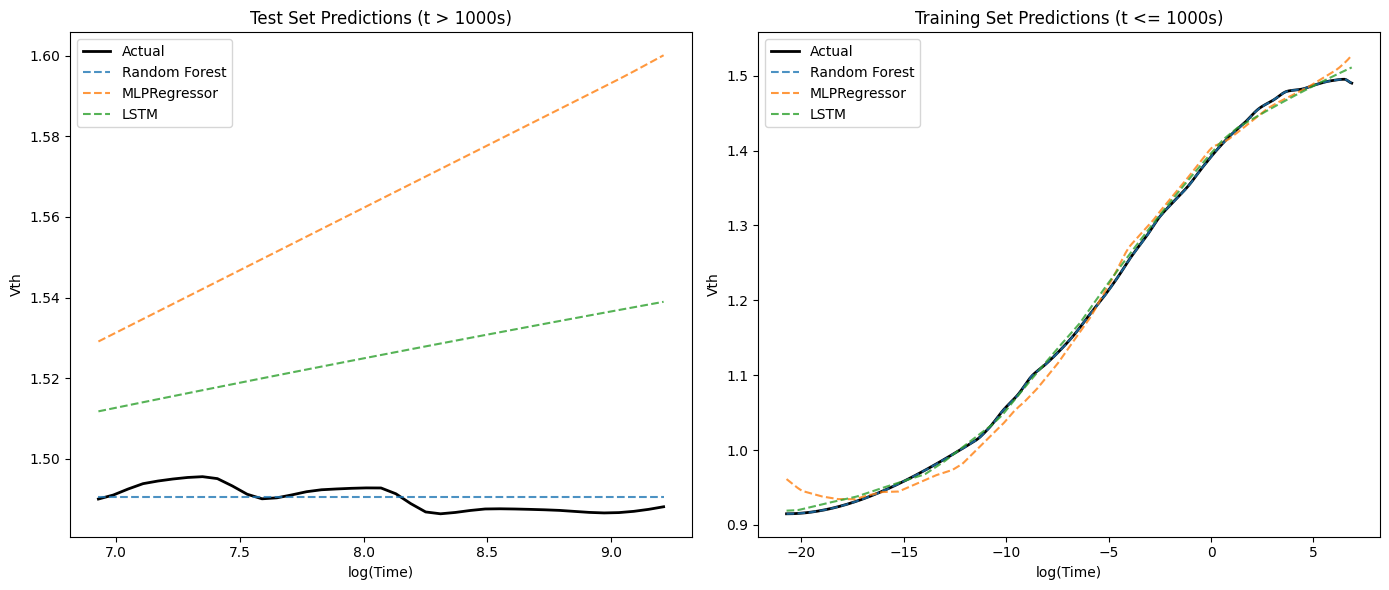

In [11]:
# Plot all predictions vs actual (test set)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(X_test, y_test, 'k-', linewidth=2, label="Actual")
plt.plot(X_test, y_pred_rf_test, '--', alpha=0.8, label="Random Forest")
plt.plot(X_test, y_pred_mlp_test, '--', alpha=0.8, label="MLPRegressor")
plt.plot(X_test, y_pred_lstm_test, '--', alpha=0.8, label="LSTM")
plt.xlabel("log(Time)")
plt.ylabel("Vth")
plt.title("Test Set Predictions (t > 1000s)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X_train, y_train, 'k-', linewidth=2, label="Actual")
plt.plot(X_train, y_pred_rf_train, '--', alpha=0.8, label="Random Forest")
plt.plot(X_train, y_pred_mlp_train, '--', alpha=0.8, label="MLPRegressor")
plt.plot(X_train, y_pred_lstm_train, '--', alpha=0.8, label="LSTM")
plt.xlabel("log(Time)")
plt.ylabel("Vth")
plt.title("Training Set Predictions (t <= 1000s)")
plt.legend()

plt.tight_layout()
plt.show()

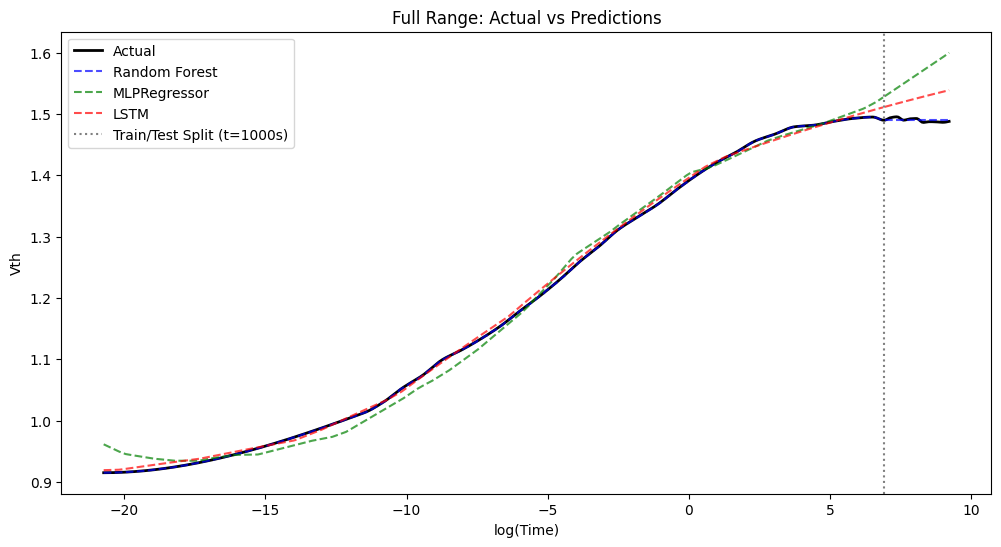

In [12]:
# Full range plot
plt.figure(figsize=(12, 6))
plt.plot(data_interp["log_t"], data_interp["vth_average"], 'k-', linewidth=2, label="Actual")
plt.plot(X_train, y_pred_rf_train, 'b--', alpha=0.7)
plt.plot(X_test, y_pred_rf_test, 'b--', alpha=0.7, label="Random Forest")
plt.plot(X_train, y_pred_mlp_train, 'g--', alpha=0.7)
plt.plot(X_test, y_pred_mlp_test, 'g--', alpha=0.7, label="MLPRegressor")
plt.plot(X_train, y_pred_lstm_train, 'r--', alpha=0.7)
plt.plot(X_test, y_pred_lstm_test, 'r--', alpha=0.7, label="LSTM")
plt.axvline(x=np.log(1000), color='gray', linestyle=':', label="Train/Test Split (t=1000s)")
plt.xlabel("log(Time)")
plt.ylabel("Vth")
plt.title("Full Range: Actual vs Predictions")
plt.legend()
plt.show()

## Metrics Summary Table

In [13]:
# Create summary table
metrics_summary = pd.DataFrame({
    "Model": ["Random Forest", "Random Forest", "MLPRegressor", "MLPRegressor", "LSTM", "LSTM"],
    "Set": ["Train", "Test", "Train", "Test", "Train", "Test"],
    "MSE": [rf_train_metrics["MSE"], rf_test_metrics["MSE"], 
            mlp_train_metrics["MSE"], mlp_test_metrics["MSE"],
            lstm_train_metrics["MSE"], lstm_test_metrics["MSE"]],
    "RMSE": [rf_train_metrics["RMSE"], rf_test_metrics["RMSE"], 
             mlp_train_metrics["RMSE"], mlp_test_metrics["RMSE"],
             lstm_train_metrics["RMSE"], lstm_test_metrics["RMSE"]],
    "MAE": [rf_train_metrics["MAE"], rf_test_metrics["MAE"], 
            mlp_train_metrics["MAE"], mlp_test_metrics["MAE"],
            lstm_train_metrics["MAE"], lstm_test_metrics["MAE"]],
    "R²": [rf_train_metrics["R2"], rf_test_metrics["R2"], 
           mlp_train_metrics["R2"], mlp_test_metrics["R2"],
           lstm_train_metrics["R2"], lstm_test_metrics["R2"]]
})

print("\n=== Metrics Summary ===")
metrics_summary


=== Metrics Summary ===


,Model,Set,MSE,RMSE,MAE,R²
0,Random Forest,Train,8.062238e-08,0.000284,0.000223,0.999998
1,Random Forest,Test,9.087158e-06,0.003014,0.002707,-0.013196
2,MLPRegressor,Train,2.070858e-04,0.014390,0.011960,0.995224
3,MLPRegressor,Test,6.075822e-03,0.077948,0.074334,-676.439442
4,LSTM,Train,3.653195e-05,0.006044,0.005208,0.999157
5,LSTM,Test,1.372573e-03,0.037048,0.035491,-152.038616


## Predict Single Value at 10000s

In [14]:
# Find closest point to 10000s in original data
idx_10000 = (np.abs(data_original["t"] - 10000)).idxmin()
actual_vth_10000 = data_original["vth_average"][idx_10000]
log_t_10000 = np.log(data_original["t"][idx_10000] + epsilon)

print(f"Actual time: {data_original['t'][idx_10000]}s")
print(f"Actual Vth at 10000s: {actual_vth_10000}")

Actual time: 10000.0s
Actual Vth at 10000s: 1.488080533


In [15]:
# Predict at 10000s
X_10000 = np.array([[log_t_10000]])
X_10000_scaled = scaler_X.transform(X_10000)
X_10000_lstm_scaled = scaler_X_lstm.transform(X_10000).reshape(1, 1, 1)

pred_rf_10000 = rf.predict(X_10000)[0]
pred_mlp_10000 = mlp.predict(X_10000_scaled)[0]
pred_lstm_10000 = scaler_y_lstm.inverse_transform(lstm_model.predict(X_10000_lstm_scaled))[0, 0]

print("\n=== Predictions at t=10000s ===")
print(f"Actual:         {actual_vth_10000:.6f}")
print(f"Random Forest:  {pred_rf_10000:.6f}  (Error: {abs(actual_vth_10000 - pred_rf_10000):.6f})")
print(f"MLPRegressor:   {pred_mlp_10000:.6f}  (Error: {abs(actual_vth_10000 - pred_mlp_10000):.6f})")
print(f"LSTM:           {pred_lstm_10000:.6f}  (Error: {abs(actual_vth_10000 - pred_lstm_10000):.6f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

=== Predictions at t=10000s ===
Actual:         1.488081
Random Forest:  1.490452  (Error: 0.002372)
MLPRegressor:   1.600103  (Error: 0.112022)
LSTM:           1.538935  (Error: 0.050854)


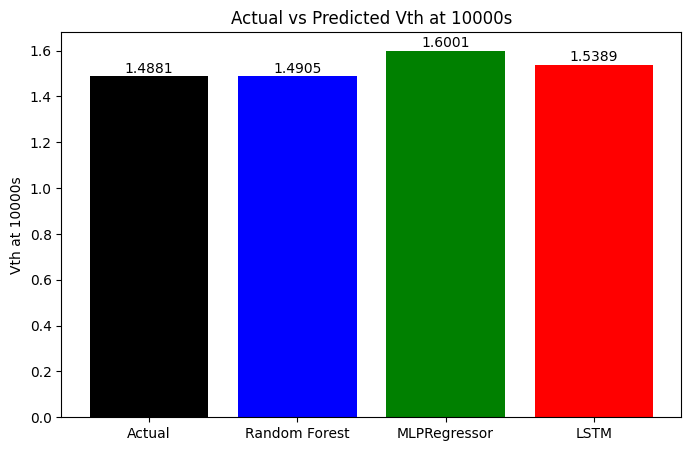

In [16]:
# Bar plot comparison
labels = ["Actual", "Random Forest", "MLPRegressor", "LSTM"]
values = [actual_vth_10000, pred_rf_10000, pred_mlp_10000, pred_lstm_10000]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=["black", "blue", "green", "red"])
plt.ylabel("Vth at 10000s")
plt.title("Actual vs Predicted Vth at 10000s")
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{val:.4f}', ha='center', va='bottom')
plt.show()

## Compare with Original Data Training
Train on original (non-interpolated) data for comparison

In [17]:
# Prepare original data
train_mask_orig = data_original["t"] <= 1000
test_mask_orig = data_original["t"] > 1000

X_train_orig = np.log(data_original["t"][train_mask_orig].values + epsilon).reshape(-1, 1)
y_train_orig = data_original["vth_average"][train_mask_orig].values

X_test_orig = np.log(data_original["t"][test_mask_orig].values + epsilon).reshape(-1, 1)
y_test_orig = data_original["vth_average"][test_mask_orig].values

print(f"Original training samples: {len(X_train_orig)}")
print(f"Original test samples: {len(X_test_orig)}")

Original training samples: 29
Original test samples: 10


In [18]:
# Train models on original data
scaler_orig = StandardScaler()
X_train_orig_scaled = scaler_orig.fit_transform(X_train_orig)
X_test_orig_scaled = scaler_orig.transform(X_test_orig)

# Random Forest
rf_orig = RandomForestRegressor(n_estimators=100, random_state=42)
rf_orig.fit(X_train_orig, y_train_orig)
y_pred_rf_orig = rf_orig.predict(X_test_orig)

# MLPRegressor
mlp_orig = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=2000, random_state=42)
mlp_orig.fit(X_train_orig_scaled, y_train_orig)
y_pred_mlp_orig = mlp_orig.predict(X_test_orig_scaled)

# LSTM on original data
scaler_X_lstm_orig = MinMaxScaler()
scaler_y_lstm_orig = MinMaxScaler()

X_train_orig_lstm_scaled = scaler_X_lstm_orig.fit_transform(X_train_orig)
X_test_orig_lstm_scaled = scaler_X_lstm_orig.transform(X_test_orig)
y_train_orig_lstm_scaled = scaler_y_lstm_orig.fit_transform(y_train_orig.reshape(-1, 1))

X_train_orig_lstm = X_train_orig_lstm_scaled.reshape((X_train_orig_lstm_scaled.shape[0], 1, 1))
X_test_orig_lstm = X_test_orig_lstm_scaled.reshape((X_test_orig_lstm_scaled.shape[0], 1, 1))

lstm_orig = Sequential([
    LSTM(64, input_shape=(1, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
lstm_orig.compile(optimizer='adam', loss='mse')
early_stop_orig = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
lstm_orig.fit(X_train_orig_lstm, y_train_orig_lstm_scaled, epochs=200, verbose=1, callbacks=[early_stop_orig])

y_pred_lstm_orig = scaler_y_lstm_orig.inverse_transform(lstm_orig.predict(X_test_orig_lstm)).flatten()

print("=== Original Data Models ===")
print("\nRandom Forest (Original):")
rf_orig_metrics = calculate_metrics(y_test_orig, y_pred_rf_orig, "Test")
print("\nMLPRegressor (Original):")
mlp_orig_metrics = calculate_metrics(y_test_orig, y_pred_mlp_orig, "Test")
print("\nLSTM (Original):")
lstm_orig_metrics = calculate_metrics(y_test_orig, y_pred_lstm_orig, "Test")

Epoch 1/200


/Users/titanjuels/Documents/HKUST/FYP/model/fypenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4993
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4908
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4843
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4780
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4710
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4637
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4561
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4487
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4426
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4333
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4281
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4186
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4110
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4026
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3939
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━

In [19]:
# Compare interpolated vs original training
comparison_df = pd.DataFrame({
    "Model": ["RF (Interpolated)", "RF (Original)", "MLP (Interpolated)", "MLP (Original)"],
    "Test MSE": [rf_test_metrics["MSE"], rf_orig_metrics["MSE"], 
                 mlp_test_metrics["MSE"], mlp_orig_metrics["MSE"]],
    "Test R²": [rf_test_metrics["R2"], rf_orig_metrics["R2"], 
                mlp_test_metrics["R2"], mlp_orig_metrics["R2"]]
})

print("\n=== Interpolated vs Original Training Comparison ===")
comparison_df


=== Interpolated vs Original Training Comparison ===


,Model,Test MSE,Test R²
0,RF (Interpolated),0.000009,-0.013196
1,RF (Original),0.000011,-0.077276
2,MLP (Interpolated),0.006076,-676.439442
3,MLP (Original),0.011493,-1107.575094


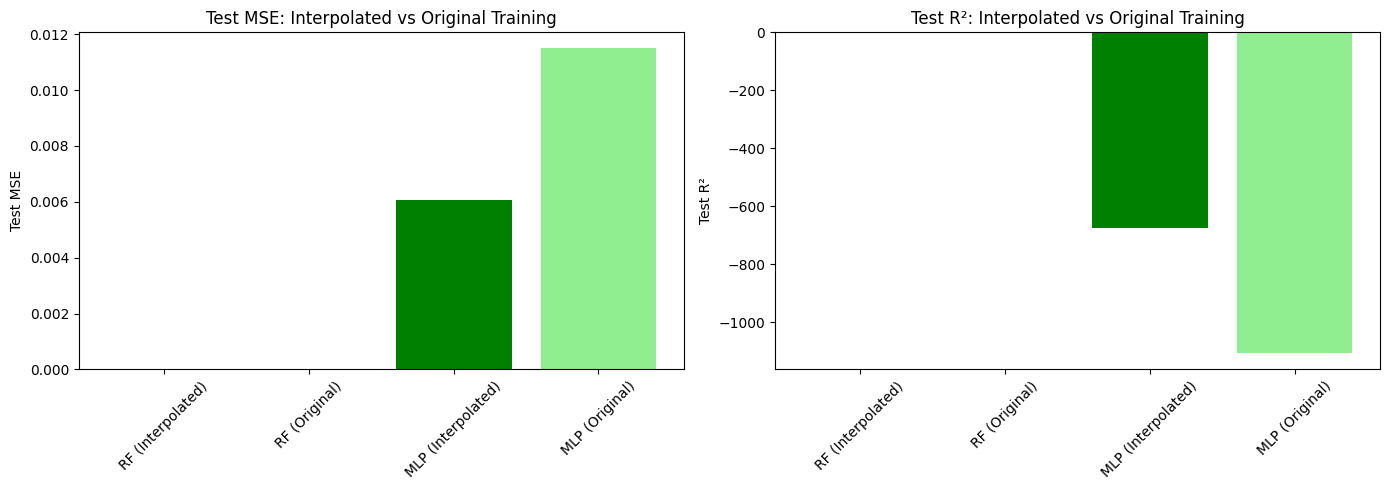

In [20]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MSE comparison
axes[0].bar(comparison_df["Model"], comparison_df["Test MSE"], color=["blue", "lightblue", "green", "lightgreen"])
axes[0].set_ylabel("Test MSE")
axes[0].set_title("Test MSE: Interpolated vs Original Training")
axes[0].tick_params(axis='x', rotation=45)

# R² comparison
axes[1].bar(comparison_df["Model"], comparison_df["Test R²"], color=["blue", "lightblue", "green", "lightgreen"])
axes[1].set_ylabel("Test R²")
axes[1].set_title("Test R²: Interpolated vs Original Training")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Predict from 10000s Onward (Like StandardModel)
Predict values from index 29 (10000s) onward using models trained on first 1000s

In [21]:
# Prepare test data for 10000s+ (using original data points for fair comparison)
idx_10000 = 29  # Index in original data where t ~ 10000s

# Get actual test values from original data
X_test_10000plus_orig = np.log(data_original["t"][idx_10000:].values + epsilon).reshape(-1, 1)
y_test_10000plus_orig = data_original["vth_average"][idx_10000:].values

# Scale for predictions
X_test_10000plus_scaled = scaler_X.transform(X_test_10000plus_orig)
X_test_10000plus_lstm = scaler_X_lstm.transform(X_test_10000plus_orig).reshape(-1, 1, 1)

# Predictions from interpolated models
y_pred_rf_10000plus_interp = rf.predict(X_test_10000plus_orig)
y_pred_mlp_10000plus_interp = mlp.predict(X_test_10000plus_scaled)
y_pred_lstm_10000plus_interp = scaler_y_lstm.inverse_transform(lstm_model.predict(X_test_10000plus_lstm)).flatten()

# Predictions from original models
X_test_10000plus_orig_scaled = scaler_orig.transform(X_test_10000plus_orig)
X_test_10000plus_orig_lstm = scaler_X_lstm_orig.transform(X_test_10000plus_orig).reshape(-1, 1, 1)

y_pred_rf_10000plus_orig = rf_orig.predict(X_test_10000plus_orig)
y_pred_mlp_10000plus_orig = mlp_orig.predict(X_test_10000plus_orig_scaled)
y_pred_lstm_10000plus_orig = scaler_y_lstm_orig.inverse_transform(lstm_orig.predict(X_test_10000plus_orig_lstm)).flatten()

print(f"Predicting {len(y_test_10000plus_orig)} points from 10000s onward")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicting 10 points from 10000s onward


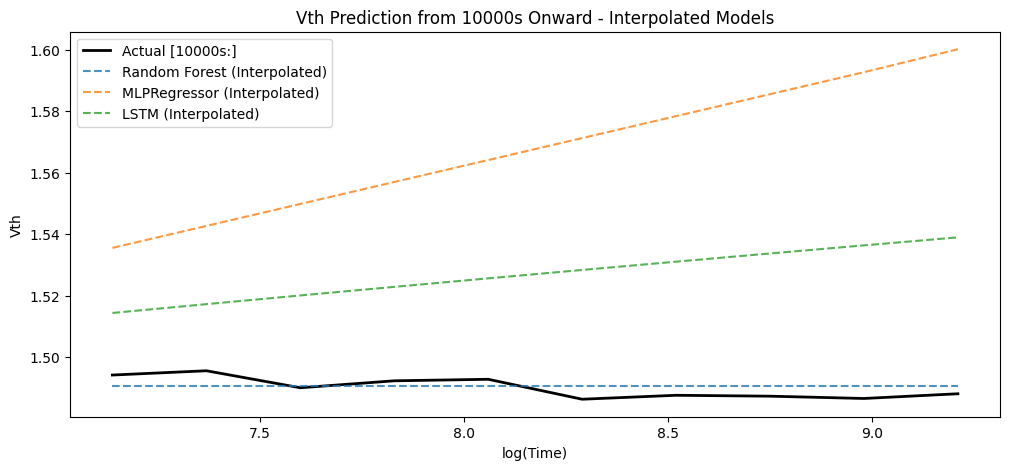

In [22]:
# Plot predictions from 10000s onward - Interpolated Models
plt.figure(figsize=(12, 5))
plt.plot(X_test_10000plus_orig, y_test_10000plus_orig, 'k-', linewidth=2, label="Actual [10000s:]")
plt.plot(X_test_10000plus_orig, y_pred_rf_10000plus_interp, '--', alpha=0.8, label="Random Forest (Interpolated)")
plt.plot(X_test_10000plus_orig, y_pred_mlp_10000plus_interp, '--', alpha=0.8, label="MLPRegressor (Interpolated)")
plt.plot(X_test_10000plus_orig, y_pred_lstm_10000plus_interp, '--', alpha=0.8, label="LSTM (Interpolated)")
plt.legend()
plt.xlabel("log(Time)")
plt.ylabel("Vth")
plt.title("Vth Prediction from 10000s Onward - Interpolated Models")
plt.show()

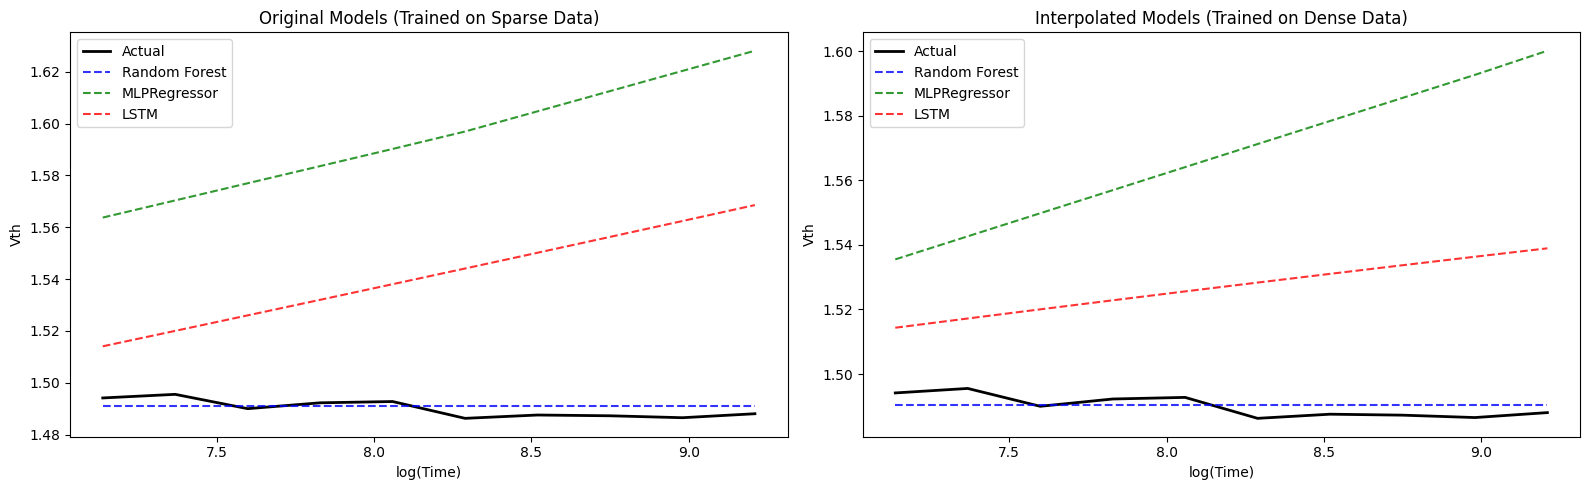

In [23]:
# Plot predictions from 10000s onward - Original vs Interpolated
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Original models (now includes LSTM)
axes[0].plot(X_test_10000plus_orig, y_test_10000plus_orig, 'k-', linewidth=2, label="Actual")
axes[0].plot(X_test_10000plus_orig, y_pred_rf_10000plus_orig, 'b--', alpha=0.8, label="Random Forest")
axes[0].plot(X_test_10000plus_orig, y_pred_mlp_10000plus_orig, 'g--', alpha=0.8, label="MLPRegressor")
axes[0].plot(X_test_10000plus_orig, y_pred_lstm_10000plus_orig, 'r--', alpha=0.8, label="LSTM")
axes[0].set_xlabel("log(Time)")
axes[0].set_ylabel("Vth")
axes[0].set_title("Original Models (Trained on Sparse Data)")
axes[0].legend()

# Interpolated models
axes[1].plot(X_test_10000plus_orig, y_test_10000plus_orig, 'k-', linewidth=2, label="Actual")
axes[1].plot(X_test_10000plus_orig, y_pred_rf_10000plus_interp, 'b--', alpha=0.8, label="Random Forest")
axes[1].plot(X_test_10000plus_orig, y_pred_mlp_10000plus_interp, 'g--', alpha=0.8, label="MLPRegressor")
axes[1].plot(X_test_10000plus_orig, y_pred_lstm_10000plus_interp, 'r--', alpha=0.8, label="LSTM")
axes[1].set_xlabel("log(Time)")
axes[1].set_ylabel("Vth")
axes[1].set_title("Interpolated Models (Trained on Dense Data)")
axes[1].legend()

plt.tight_layout()
plt.show()

## Direct Comparison: Original vs Interpolated Training
MSE and other metrics for predictions from 10000s onward

In [24]:
# Calculate metrics for 10000s+ predictions
print("=== Metrics for Predictions from 10000s Onward ===")

print("\n--- Original Models (Sparse Training Data) ---")
rf_orig_10000_metrics = calculate_metrics(y_test_10000plus_orig, y_pred_rf_10000plus_orig, "Random Forest (Original)")
mlp_orig_10000_metrics = calculate_metrics(y_test_10000plus_orig, y_pred_mlp_10000plus_orig, "MLPRegressor (Original)")
lstm_orig_10000_metrics = calculate_metrics(y_test_10000plus_orig, y_pred_lstm_10000plus_orig, "LSTM (Original)")

print("\n--- Interpolated Models (Dense Training Data) ---")
rf_interp_10000_metrics = calculate_metrics(y_test_10000plus_orig, y_pred_rf_10000plus_interp, "Random Forest (Interpolated)")
mlp_interp_10000_metrics = calculate_metrics(y_test_10000plus_orig, y_pred_mlp_10000plus_interp, "MLPRegressor (Interpolated)")
lstm_interp_10000_metrics = calculate_metrics(y_test_10000plus_orig, y_pred_lstm_10000plus_interp, "LSTM (Interpolated)")

=== Metrics for Predictions from 10000s Onward ===

--- Original Models (Sparse Training Data) ---

Random Forest (Original):
  MSE:  0.000011
  RMSE: 0.003342
  MAE:  0.003088
  R²:   -0.077276

MLPRegressor (Original):
  MSE:  0.011493
  RMSE: 0.107207
  MAE:  0.104669
  R²:   -1107.575094

LSTM (Original):
  MSE:  0.003016
  RMSE: 0.054918
  MAE:  0.051102
  R²:   -289.899486

--- Interpolated Models (Dense Training Data) ---

Random Forest (Interpolated):
  MSE:  0.000011
  RMSE: 0.003243
  MAE:  0.002987
  R²:   -0.014457

MLPRegressor (Interpolated):
  MSE:  0.006565
  RMSE: 0.081023
  MAE:  0.077607
  R²:   -632.199439

LSTM (Interpolated):
  MSE:  0.001466
  RMSE: 0.038286
  MAE:  0.036772
  R²:   -140.384662


In [25]:
# Create comprehensive comparison table
comparison_10000_df = pd.DataFrame({
    "Model": [
        "RF (Original)", "RF (Interpolated)",
        "MLP (Original)", "MLP (Interpolated)",
        "LSTM (Interpolated)"
    ],
    "MSE": [
        rf_orig_10000_metrics["MSE"], rf_interp_10000_metrics["MSE"],
        mlp_orig_10000_metrics["MSE"], mlp_interp_10000_metrics["MSE"],
        lstm_interp_10000_metrics["MSE"]
    ],
    "RMSE": [
        rf_orig_10000_metrics["RMSE"], rf_interp_10000_metrics["RMSE"],
        mlp_orig_10000_metrics["RMSE"], mlp_interp_10000_metrics["RMSE"],
        lstm_interp_10000_metrics["RMSE"]
    ],
    "MAE": [
        rf_orig_10000_metrics["MAE"], rf_interp_10000_metrics["MAE"],
        mlp_orig_10000_metrics["MAE"], mlp_interp_10000_metrics["MAE"],
        lstm_interp_10000_metrics["MAE"]
    ],
    "R²": [
        rf_orig_10000_metrics["R2"], rf_interp_10000_metrics["R2"],
        mlp_orig_10000_metrics["R2"], mlp_interp_10000_metrics["R2"],
        lstm_interp_10000_metrics["R2"]
    ]
})

print("\n=== Comparison Table: Predictions from 10000s Onward ===")
comparison_10000_df


=== Comparison Table: Predictions from 10000s Onward ===


,Model,MSE,RMSE,MAE,R²
0,RF (Original),0.000011,0.003342,0.003088,-0.077276
1,RF (Interpolated),0.000011,0.003243,0.002987,-0.014457
2,MLP (Original),0.011493,0.107207,0.104669,-1107.575094
3,MLP (Interpolated),0.006565,0.081023,0.077607,-632.199439
4,LSTM (Interpolated),0.001466,0.038286,0.036772,-140.384662


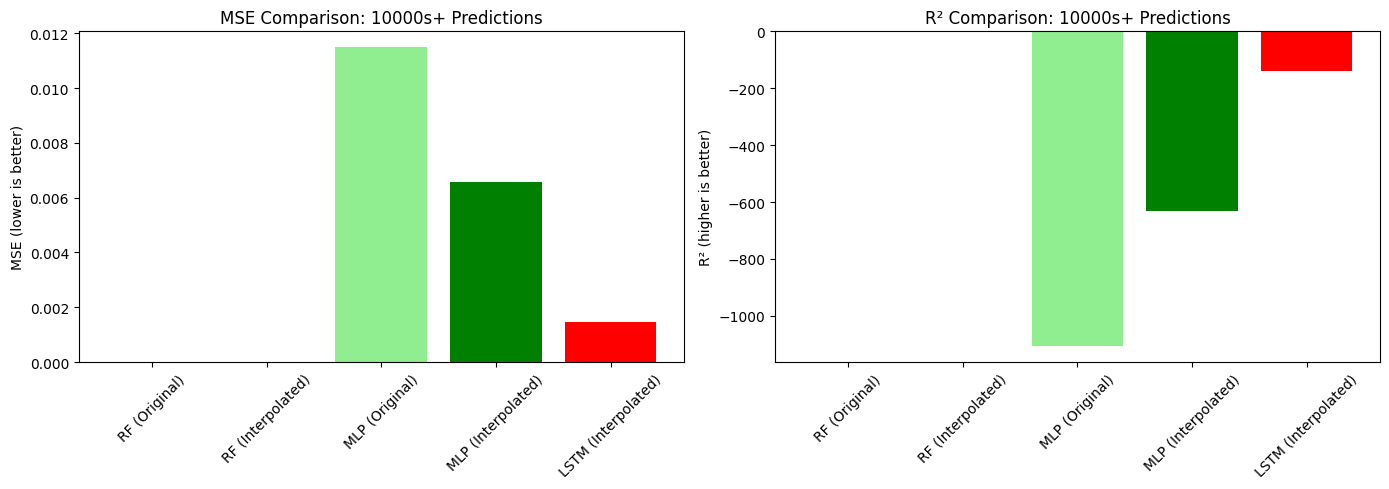

In [26]:
# Bar chart comparison of MSE and R²
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['lightblue', 'blue', 'lightgreen', 'green', 'red']

# MSE comparison
axes[0].bar(comparison_10000_df["Model"], comparison_10000_df["MSE"], color=colors)
axes[0].set_ylabel("MSE (lower is better)")
axes[0].set_title("MSE Comparison: 10000s+ Predictions")
axes[0].tick_params(axis='x', rotation=45)

# R² comparison
axes[1].bar(comparison_10000_df["Model"], comparison_10000_df["R²"], color=colors)
axes[1].set_ylabel("R² (higher is better)")
axes[1].set_title("R² Comparison: 10000s+ Predictions")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [27]:
# Single value prediction at exactly 10000s - Compare all models
print("\n=== Single Value Prediction at t=10000s ===")
print(f"Actual Vth at 10000s: {actual_vth_10000:.6f}")
print()
print("--- Original Models ---")
print(f"Random Forest (Original):      {y_pred_rf_10000plus_orig[0]:.6f}  (Error: {abs(actual_vth_10000 - y_pred_rf_10000plus_orig[0]):.6f})")
print(f"MLPRegressor (Original):       {y_pred_mlp_10000plus_orig[0]:.6f}  (Error: {abs(actual_vth_10000 - y_pred_mlp_10000plus_orig[0]):.6f})")
print()
print("--- Interpolated Models ---")
print(f"Random Forest (Interpolated):  {y_pred_rf_10000plus_interp[0]:.6f}  (Error: {abs(actual_vth_10000 - y_pred_rf_10000plus_interp[0]):.6f})")
print(f"MLPRegressor (Interpolated):   {y_pred_mlp_10000plus_interp[0]:.6f}  (Error: {abs(actual_vth_10000 - y_pred_mlp_10000plus_interp[0]):.6f})")
print(f"LSTM (Interpolated):           {y_pred_lstm_10000plus_interp[0]:.6f}  (Error: {abs(actual_vth_10000 - y_pred_lstm_10000plus_interp[0]):.6f})")


=== Single Value Prediction at t=10000s ===
Actual Vth at 10000s: 1.488081

--- Original Models ---
Random Forest (Original):      1.490960  (Error: 0.002880)
MLPRegressor (Original):       1.563734  (Error: 0.075653)

--- Interpolated Models ---
Random Forest (Interpolated):  1.490452  (Error: 0.002372)
MLPRegressor (Interpolated):   1.535510  (Error: 0.047429)
LSTM (Interpolated):           1.514355  (Error: 0.026274)


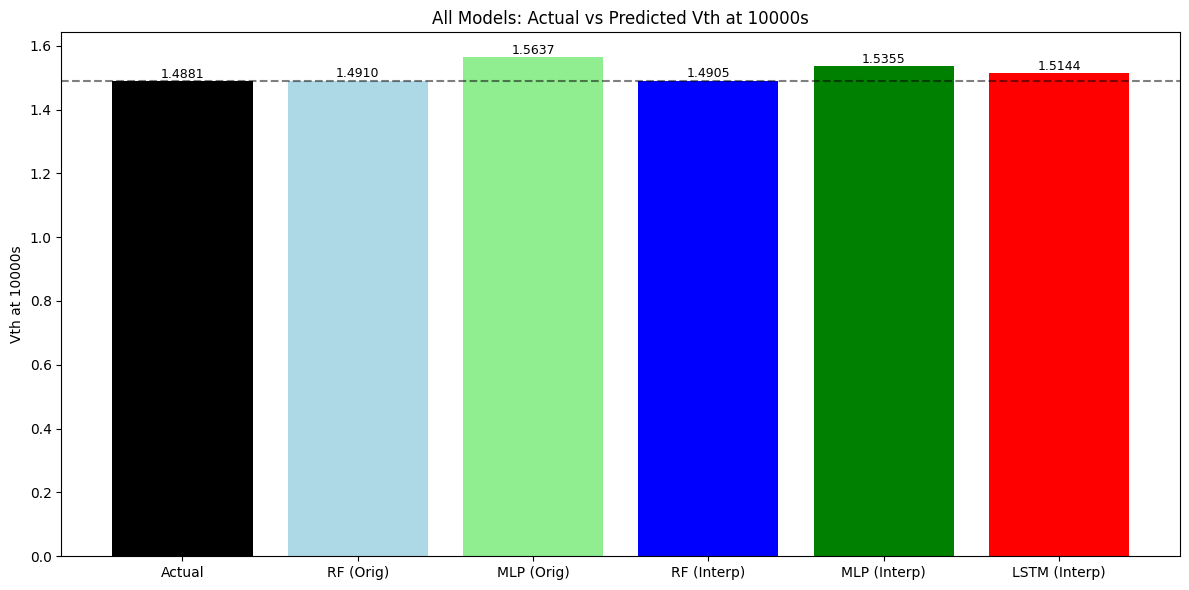

In [28]:
# Bar plot: All models prediction at 10000s
labels = ["Actual", "RF (Orig)", "MLP (Orig)", "RF (Interp)", "MLP (Interp)", "LSTM (Interp)"]
values = [
    actual_vth_10000, 
    y_pred_rf_10000plus_orig[0], 
    y_pred_mlp_10000plus_orig[0],
    y_pred_rf_10000plus_interp[0], 
    y_pred_mlp_10000plus_interp[0], 
    y_pred_lstm_10000plus_interp[0]
]
colors = ["black", "lightblue", "lightgreen", "blue", "green", "red"]

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=colors)
plt.ylabel("Vth at 10000s")
plt.title("All Models: Actual vs Predicted Vth at 10000s")
plt.axhline(y=actual_vth_10000, color='black', linestyle='--', alpha=0.5)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{val:.4f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

## Summary: Original vs Interpolated Training
- **Original training**: Uses sparse data (~29 points for first 1000s)
- **Interpolated training**: Uses dense interpolated data (~500 points)

Lower MSE and higher R² indicate better model performance.

In [29]:
# Print improvement summary
print("=== Improvement Summary (10000s+ Predictions) ===\n")

# Random Forest improvement
rf_mse_improvement = (rf_orig_10000_metrics["MSE"] - rf_interp_10000_metrics["MSE"]) / rf_orig_10000_metrics["MSE"] * 100
rf_r2_improvement = rf_interp_10000_metrics["R2"] - rf_orig_10000_metrics["R2"]

print(f"Random Forest:")
print(f"  MSE improvement: {rf_mse_improvement:+.2f}% (Negative = interpolated is worse)")
print(f"  R² improvement:  {rf_r2_improvement:+.4f}")

# MLP improvement
mlp_mse_improvement = (mlp_orig_10000_metrics["MSE"] - mlp_interp_10000_metrics["MSE"]) / mlp_orig_10000_metrics["MSE"] * 100
mlp_r2_improvement = mlp_interp_10000_metrics["R2"] - mlp_orig_10000_metrics["R2"]

print(f"\nMLPRegressor:")
print(f"  MSE improvement: {mlp_mse_improvement:+.2f}% (Negative = interpolated is worse)")
print(f"  R² improvement:  {mlp_r2_improvement:+.4f}")

print(f"\nLSTM (Interpolated only):")
print(f"  MSE: {lstm_interp_10000_metrics['MSE']:.6f}")
print(f"  R²:  {lstm_interp_10000_metrics['R2']:.4f}")

=== Improvement Summary (10000s+ Predictions) ===

Random Forest:
  MSE improvement: +5.83% (Negative = interpolated is worse)
  R² improvement:  +0.0628

MLPRegressor:
  MSE improvement: +42.88% (Negative = interpolated is worse)
  R² improvement:  +475.3757

LSTM (Interpolated only):
  MSE: 0.001466
  R²:  -140.3847
